In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
import csv
from scipy.interpolate import griddata
from PIL import Image
from matplotlib.colors import LogNorm
os.chdir('/Users/walu/lle_25/RE03/build')

In [3]:
def convert_to_csv(input_file, output_file):

    # Define the header (based on your data format)
    header = ["iX", "iY", "iZ", "dose", "total_val_squared", "entry"]

    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        writer = csv.writer(outfile)

        # Write the header row
        writer.writerow(header)

        for line in infile:
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Parse and clean the line
            values = [v.strip() for v in line.strip().split(',')]
            writer.writerow(values)


In [96]:
input_file = 'dDeposit.txt'
output_file = 'dDeposit.csv'
convert_to_csv(input_file, output_file)

<Axes: >

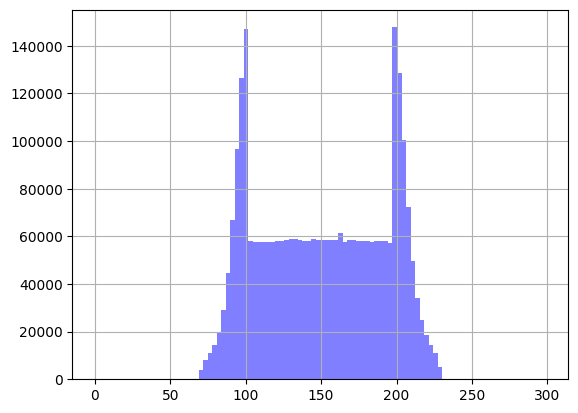

In [97]:

# Load the data
df = pd.read_csv("dDeposit.csv")
df['iZ'][df['dose'] > 0].hist(bins=100, alpha=0.5, color='blue', label='dose > 0')

In [98]:
most_common_iZ = df[df['dose'] > 0]['iZ'].value_counts().idxmax()
print("Most common iZ with dose > 0:", most_common_iZ)


Most common iZ with dose > 0: 198


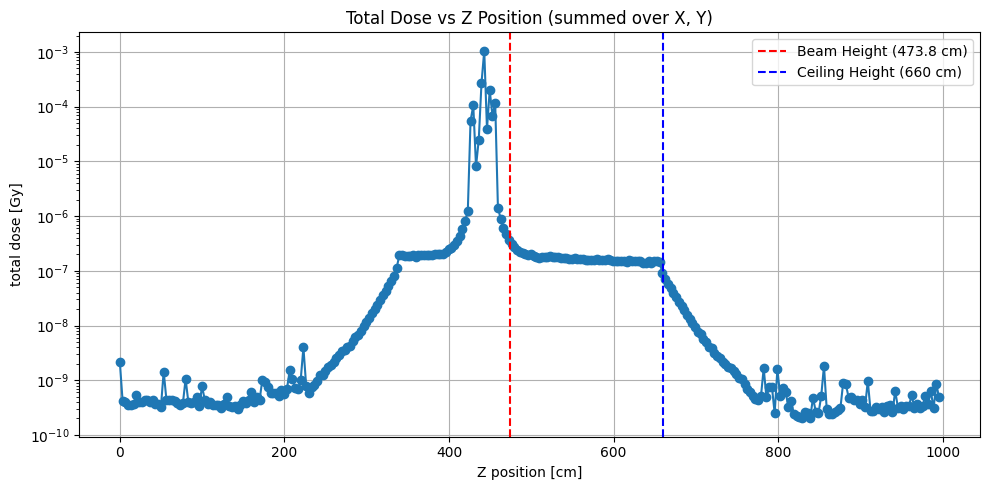

In [167]:
dose_per_z = df.groupby('iZ')['dose'].sum()

# Convert z index to physical position in cm
z_cm = dose_per_z.index * 3.33

# Compute log10 dose, avoiding log(0)
dose_log = dose_per_z.replace(0, np.nan)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(z_cm, dose_log, marker='o', linestyle='-')
plt.axvline(x=473.8, color='red', linestyle='--', label='Beam Height (473.8 cm)')
plt.axvline(x=660., color='blue', linestyle='--', label='Ceiling Height (660 cm)')
plt.xlabel('Z position [cm]')
plt.ylabel('total dose [Gy]')
plt.yscale('log')
plt.title('Total Dose vs Z Position (summed over X, Y)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [125]:
log_heatmap_data.to_csv('heatmap_data.csv')

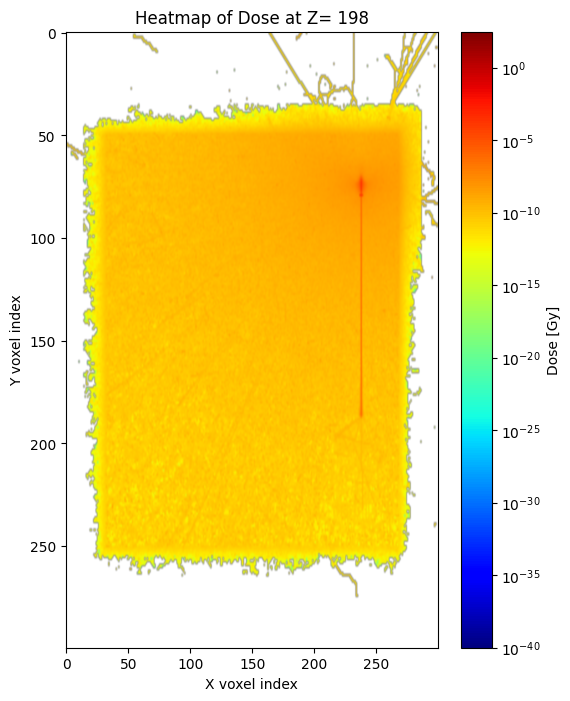

In [180]:


# Choose a Y slice to visualize, e.g., y = 0
z_slice = 198
#df_slice = df[df['iZ'] == z_slice]
df_slice = df.groupby(['iX', 'iY'])['dose'].sum().reset_index()


# Create pivot table for heatmap (e.g., X vs Z dose values)
heatmap_data = df_slice.pivot(index='iY', columns='iX', values='dose')

# Sort the index if necessary (Z-axis is usually vertical in heatmaps)
heatmap_data = heatmap_data.sort_index(ascending=False)
log_heatmap_data = heatmap_data 
# Fill NaN values with 0 for plotting
log_heatmap_data = log_heatmap_data.fillna(0)

# Plotting
plt.figure(figsize=(6, 8))
plt.imshow(log_heatmap_data, cmap='jet', interpolation='bicubic', aspect='auto', norm=LogNorm(vmin=1e-40, vmax=df_slice.values.max()))
plt.colorbar(label='Dose [Gy]')
plt.title(f'Heatmap of Dose at Z= {z_slice}')
plt.xlabel('X voxel index')
plt.ylabel('Y voxel index')
plt.show()


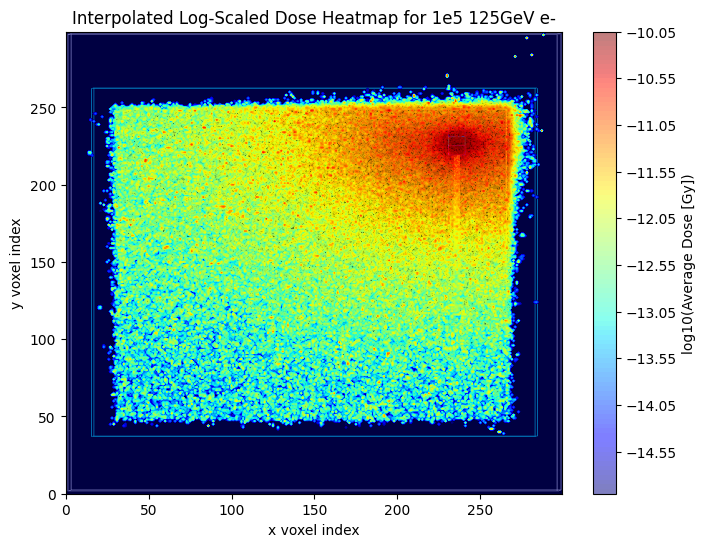

In [115]:
# Load data
z_slice = 198
#df = pd.read_csv("dDeposit.csv")
#df_avg = df.groupby(['iX', 'iY'])['dose'].mean().reset_index()
df_avg = df_slice = df[df['iZ'] == z_slice]


df_slice = df[df['iZ'] == z_slice]

# Coordinates and values
x = df_avg['iX'].values
y = df_avg['iY'].values
z = np.log10(df_avg['dose'].values + 1e-15)

# Create grid to interpolate on
xi = np.linspace(min(x), max(x), 300)
yi = np.linspace(min(y), max(y), 300)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi = griddata((x, y), z, (xi, yi), method='cubic')

#Loading bg image
# Load background geometry image
bg_img = Image.open("detector_overlay.png")
bg_array = np.array(bg_img)
bg_array = np.flipud(bg_img)
plt.figure(figsize=(8, 6))



# Plot
contour = plt.contourf(xi, yi, zi, levels=100, cmap='jet', alpha = 0.5)  # Notice yi and xi order
plt.colorbar(contour, label='log10(Average Dose [Gy])')
plt.title("Interpolated Log-Scaled Dose Heatmap for 1e5 125GeV e-")
plt.xlabel("x voxel index")
plt.ylabel("y voxel index")

plt.imshow(
    bg_array,
    extent=[min(y), max(y), min(x), max(x)],  # align with voxel coordinates
    origin='lower',
    aspect='auto'
)

plt.show()

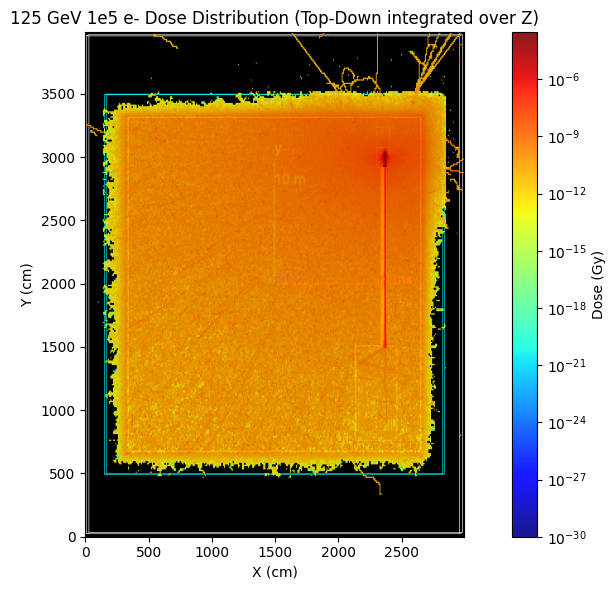

In [182]:
# --- Load your data ---
# df = pd.read_csv("dDeposit.csv")  # Already assumed to be loaded

# --- Step 1: Sum dose over Z for top-down view ---
df_topdown = df.groupby(['iX', 'iY'])['dose'].sum().reset_index()

# --- Step 2: Convert voxel indices to cm ---
df_topdown['x_cm'] = df_topdown['iX'] * 10       # 10 cm per voxel in x
df_topdown['y_cm'] = df_topdown['iY'] * 13.33    # 13.33 cm per voxel in y

# --- Step 3: Pivot to 2D array for plotting ---
heatmap_data = df_topdown.pivot(index='y_cm', columns='x_cm', values='dose')

# --- Step 4: Prepare data (log scale friendly) ---
heatmap_data = heatmap_data.fillna(0)
heatmap_data[heatmap_data <= 0] = 0

# --- Step 5: Load background geometry image ---
bg_img = Image.open("detector_overlay.png")
bg_array = np.array(bg_img)
bg_array = np.flipud(bg_array)  # Flip vertically if needed to match orientation

# --- Step 6: Plot ---
plt.figure(figsize=(10, 6))

# Background image
plt.imshow(
    bg_array,
    extent=[
        df_topdown['x_cm'].min(),
        df_topdown['x_cm'].max(),
        df_topdown['y_cm'].min(),
        df_topdown['y_cm'].max()
    ],
    origin='lower',
    aspect='auto',
    alpha=1.0
)

# Dose overlay
plt.imshow(
    heatmap_data,
    extent=[
        heatmap_data.columns.min(), heatmap_data.columns.max(),
        heatmap_data.index.min(), heatmap_data.index.max()
    ],
    origin='lower',
    cmap='jet',
    norm=LogNorm(vmin=1e-30, vmax=heatmap_data.values.max()),
    alpha=0.9
)

plt.colorbar(label='Dose (Gy)')
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.title('125 GeV 1e5 e- Dose Distribution (Top-Down integrated over Z)')
plt.tight_layout()
plt.show()
